# Train-test-val split
## Requirements:
- Split 80 - 20 (Due to small dataset size, I think we should omit a validation set)
- No two photos taken at the same encounter (location+bear) should be end up in different sets. In other words, the 'atoms' are the encounters, they can not be split any more.

## Types of (re-)identification
I identify three different forms of (re-)identification:
1. Confirmation: two images are of the same individual
2. Closed-set identification: assign probe image to correct individual (cluster of images)
3. Open-set identification: assign probe image to correct individual, or create new one if no match.

I think type 3 is closest to the real-world scenario, so we should focus on this type. We can evaluate by gallery querying.
To do so and to avoid data leakage we should split by individual.

## Evaluation
Evaluation is done by using gallery querying. We split the test set into a gallery and a set of query images (k-fold).
Then we calculate the mAP@K metric for different k, meaning: we check if the correct individual is in the top-k individuals as predicted by the model.
How we actually query is to be decided. You could for example consider each image separately or create a centroid (mean of embeddings of 1 individual).
During evaluation, photos of the same individual at the same moment should be omitted as it messes with the metric scores.

First, we will create a single dataframe containing every image in the set and the corresponding metadata, that is, origin dir (brookFalls/britishColumbia) individual id and 'encounter' (subdir).

In [32]:
import os
import pandas as pd
from pathlib import Path
import random
import matplotlib.pyplot as plt
import logging
import yaml
from tqdm.notebook import tqdm

import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset

In [33]:
"""The root dir contains the chip directories brooksFalls and britishColumbia
"""
root_dir = Path("../../../data/07_model_output/bearfacesegmentation/chips/yolov8/resized/square_dim_300/")

In [34]:
def list_subdirs(dir):
  return [item for item in os.listdir(dir) if os.path.isdir(os.path.join(dir, item))]


def collect_samples(root_dir: Path, allowed_origins: list[str]) -> list[dict]:
    # Locate every chip in the dataset
    samples = []
    
    for origin in allowed_origins:
        for encounter in list_subdirs(root_dir / origin):
            for bear_id in list_subdirs(root_dir / origin / encounter):
                for image in os.listdir(root_dir / origin / encounter / bear_id):
                    image_path = root_dir / origin / encounter / bear_id / image
                    samples.append({
                        "origin": origin,
                        "encounter": encounter,
                        "bear_id": bear_id,
                        "image": image,
                        "path_data_relative": image_path.relative_to(Path("../../../")),
                        "path": image_path,
                        })
    return samples

In [35]:
def resize_dataframe(df: pd.DataFrame, threshold_value: int) -> pd.DataFrame:
    return df.groupby("bear_id").filter(lambda x: len(x) > threshold_value)

In [36]:
def filter_dataframe(df) -> dict:
    """
    Filters the dataframe based on rules. Keep only rows where there are more than 1 bear images.
    """
    # Discard rows where bear_id occurs only once
    df_filtered = df.groupby('bear_id').filter(lambda x: len(x) > 1)
    logging.info(f"Discarded {len(df) - len(df_filtered)} rows")
    df_one_individual = df.groupby('bear_id').filter(lambda x: len(x) == 1)
    
    return {
        "df_filtered": df_filtered, 
        "df_one_individual": df_one_individual,
    }

# FIXME: rename to train_test_split_by_individual
def train_test_split(df_raw: pd.DataFrame, train_size: float = 0.7, random_seed: int = 0) -> pd.DataFrame:
    """
    Adds a `split` column with values in {train, test} depending on the train_size and the random_seed.

    Bears with more than one encounter are split into train and test sets according to the `train_size` ratio.
    All the bears with only one encounter are placed in the test set.
    """
    
    d = filter_dataframe(df_raw)
    df_filtered, df_one_individual = d["df_filtered"], d["df_one_individual"]

    bears = [x for _, x in df_filtered.groupby("bear_id")]
    single_bears = [x for _, x in df_one_individual.groupby("bear_id")]
    
    shuffled_bears = random.Random(random_seed).sample(bears, len(bears))
    train_split = shuffled_bears[:int(train_size * len(shuffled_bears))]
    test_split = shuffled_bears[int(train_size * len(shuffled_bears)):]
    test_split.extend(single_bears) # We can use the individuals with one image during testing
    df_train = pd.concat(train_split)
    df_train["split"] = "train"
    df_test = pd.concat(test_split)
    df_test["split"] = "test"

    return pd.concat([df_train, df_test])

In [37]:
class MyDumper(yaml.Dumper):
    def increase_indent(self, flow=False, indentless=False):
        return super(MyDumper, self).increase_indent(flow, False)


def write_config_yaml(
    path: Path,
    df: pd.DataFrame,
    train_size_ratio: float,
    random_seed: int,
    allowed_origins: list[str],
    root_dir: Path,
    threshold_value: int,
) -> None:
    """Writes the `config.yaml` file that describes the generated datasplit."""
    
    data = {
        "train_size_ratio": train_size_ratio,
        "train_dataset_size": len(df[df["split"] == "train"]),
        "test_dataset_size": len(df[df["split"] == "test"]),
        "train_dataset_number_individuals":  len(df[df["split"] == "train"].bear_id.unique()),
        "test_dataset_number_individuals":  len(df[df["split"] == "test"].bear_id.unique()),
        "random_seed": random_seed,
        "allowed_origins": allowed_origins, 
        "root_dir": str(root_dir),
        "threshold_value": threshold_value,
    }

    with open(path / "config.yaml", "w") as f:
        yaml.dump(data, f, Dumper=MyDumper, default_flow_style=False, sort_keys=False)

In [38]:
def build_datasplit(root_dir: Path, allowed_origins: list[str], threshold_value: int, random_seed: int = 0, train_size: float = 0.7) -> pd.DataFrame:
    
    samples = collect_samples(root_dir=root_dir, allowed_origins=allowed_origins)
    df_raw = pd.DataFrame(samples)
    df_resized = resize_dataframe(df_raw, threshold_value=threshold_value)

    df = train_test_split(
        df_raw=df_resized, 
        train_size=train_size, 
        random_seed=random_seed,
    )

    df_train = df[df["split"] == "train"]
    df_test = df[df["split"] == "test"]

    # Sanity check
    assert len(df_resized.bear_id.unique()) == len(df_train.bear_id.unique()) + len(df_test.bear_id.unique())
    
    return df

In [39]:
def save_datasplit(df: pd.DataFrame, save_dir: Path, threshold_value: int, allowed_origins: list[str], random_seed: int = 0, train_size: float = 0.7) -> None:
    os.makedirs(save_dir, exist_ok=True)
    output_filepath = save_dir / "data_split.csv"
    print(f"Saving split in {output_filepath}")
    df.to_csv(output_filepath, sep=';', index=False)
    write_config_yaml(
        path=save_dir,
        df=df,
        train_size_ratio=train_size,
        random_seed=random_seed,
        allowed_origins=allowed_origins,
        root_dir=root_dir,
        threshold_value=threshold_value,
    )

def save_all_datasplits(thresholds: dict, allowed_origins: list[str], random_seed: int, train_size: float) -> None:
    for threshold_key in tqdm(thresholds.keys()):
        print(f"generating datasplit for key: {threshold_key}")
        threshold_value = thresholds[threshold_key]
        df = build_datasplit(root_dir=root_dir, allowed_origins=allowed_origins, threshold_value=threshold_value, random_seed=random_seed, train_size=train_size)
        save_dir = Path(f"../../../data/04_feature/bearidentification/bearid/data_split/by_individual/{threshold_key}/")
        save_datasplit(df=df, save_dir=save_dir, threshold_value=threshold_value, allowed_origins=allowed_origins, random_seed=random_seed, train_size=train_size)

In [40]:
"""
threshold key to number of individual by bear id.
"""
thresholds = {"nano": 150, "small": 100, "medium": 50, "large": 10, "full": 0}
random_seed = 0
train_size = 0.7
# allowed_origins = ["brooksFalls", "britishColumbia"]
allowed_origins = ["brooksFalls"]

save_all_datasplits(thresholds=thresholds, allowed_origins=allowed_origins, random_seed=random_seed, train_size=train_size)

  0%|          | 0/5 [00:00<?, ?it/s]

generating datasplit for key: nano
Saving split in ../../../data/04_feature/bearidentification/bearid/data_split/by_individual/nano/data_split.csv
generating datasplit for key: small
Saving split in ../../../data/04_feature/bearidentification/bearid/data_split/by_individual/small/data_split.csv
generating datasplit for key: medium
Saving split in ../../../data/04_feature/bearidentification/bearid/data_split/by_individual/medium/data_split.csv
generating datasplit for key: large
Saving split in ../../../data/04_feature/bearidentification/bearid/data_split/by_individual/large/data_split.csv
generating datasplit for key: full
Saving split in ../../../data/04_feature/bearidentification/bearid/data_split/by_individual/full/data_split.csv


In [41]:
class BearTripletDataset(Dataset):
    def __init__(self, dataframe, train=True, transform=None):
        self.dataframe = dataframe
        self.train = train
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.train:
            # Sample a triplet
            anchor_sample = self.dataframe.iloc[idx]
            bear_id = anchor_sample['bear_id']
            encounter_id = anchor_sample['encounter']
            path = anchor_sample['path']

            # Get all samples for the same bear_id
            bear_samples = self.dataframe[self.dataframe.bear_id == bear_id]

            # Filter out the anchor's encounter if there is more than 1
            if len(bear_samples.encounter.unique()) > 1:
                possible_positives = bear_samples[bear_samples.encounter != encounter_id]
                # possible_positives = [sample for sample in bear_samples if sample['encounter'] != encounter_id]
            else:
                # If not, we can select from the same encounter
                possible_positives = bear_samples[bear_samples.path != path]

            positive_sample = possible_positives.sample()

            # Select a negative sample from a different bear
            other_bears = self.dataframe[self.dataframe.bear_id != bear_id]
            negative_sample = other_bears.sample()

            anchor_path = path
            positive_path = positive_sample.path.item()
            negative_path = negative_sample.path.item()

            anchor_image = Image.open(anchor_path)
            positive_image = Image.open(positive_path)
            negative_image = Image.open(negative_path)

            if self.transform:
                anchor_image = self.transform(anchor_image)
                positive_image = self.transform(positive_image)
                negative_image = self.transform(negative_image)

            return {'anchor': anchor_image, 'positive': positive_image, 'negative': negative_image}

        else:
            # Testing logic to fetch a single image per encounter
            sample = self.dataframe.iloc[idx]
            image = Image.open(sample.path)
            if self.transform:
                image = self.transform(image)
            return sample.bear_id, image

In [42]:
def display_triplet(sample):
    fig, ax = plt.subplot_mosaic([["anchor", "positive", "negative"]], figsize = (10,4))
    ax["anchor"].imshow(sample["anchor"])
    ax["anchor"].axis("off")
    ax["anchor"].set_title("anchor")
    ax["positive"].imshow(sample["positive"])
    ax["positive"].axis("off")
    ax["positive"].set_title("positive")
    ax["negative"].imshow(sample["negative"])
    ax["negative"].axis("off")
    ax["negative"].set_title("negative")
    plt.show()

def display_test_sample(bear_id, path):
    fig, ax = plt.subplot_mosaic([["sample"]], figsize = (3,3))
    ax["sample"].imshow(path)
    ax["sample"].axis("off")
    ax["sample"].set_title(f"{bear_id}")
    plt.show()

def visualize_samples(train_dataset: Dataset, test_dataset: Dataset) -> None:
    # Testing the training dataset
    print("Training Samples:")
    for i in range(min(5, len(train_dataset))):
        sample = train_dataset[i]
        display_triplet(sample)
    
    # Testing the testing dataset
    print("\nTesting Samples:")
    for i in range(min(5, len(test_dataset))):
        bear_id, image = test_dataset[i]
        display_test_sample(bear_id, image)

Training Samples:


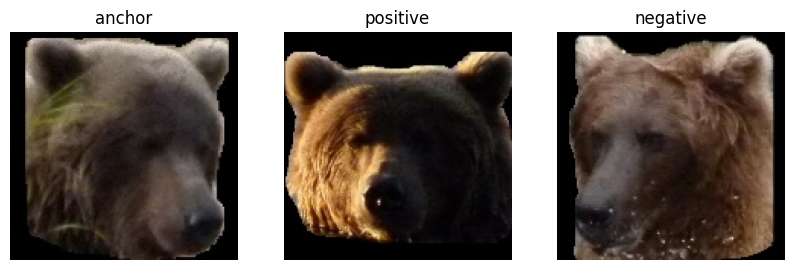

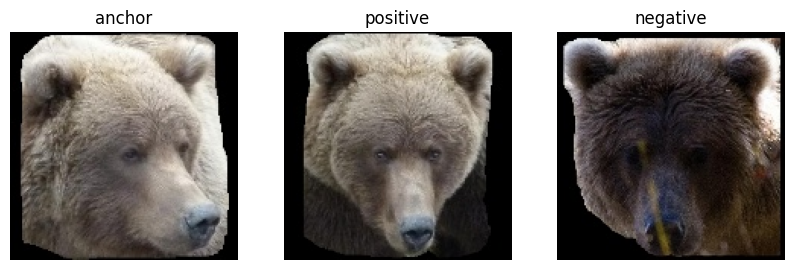

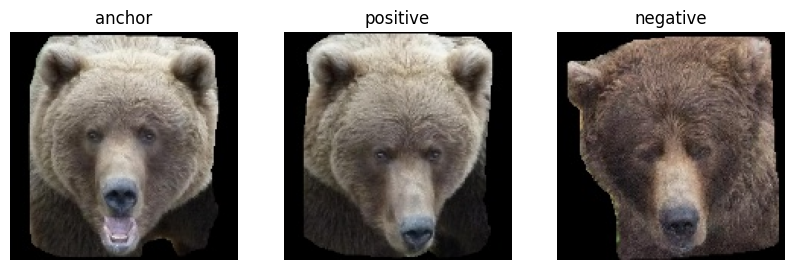

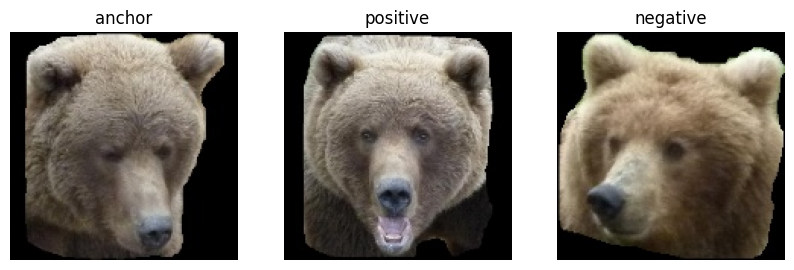

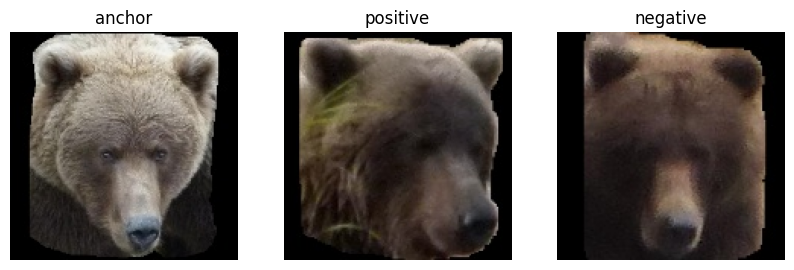


Testing Samples:


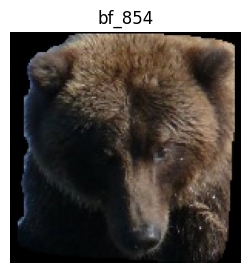

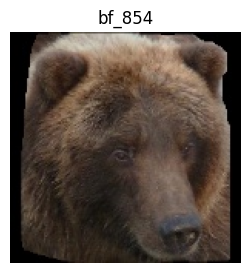

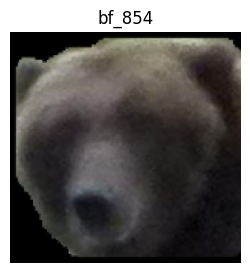

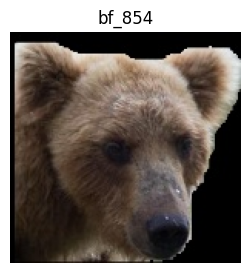

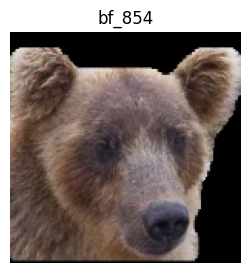

In [43]:
build_datasplit(root_dir=root_dir, allowed_origins=allowed_origins, threshold_value=0, random_seed=0, train_size=0.7)

df_train = df[df["split"] == "train"]
df_test = df[df["split"] == "test"]

train_dataset = BearTripletDataset(df_train, train=True)
test_dataset = BearTripletDataset(df_test, train=False)

visualize_samples(train_dataset=train_dataset, test_dataset=test_dataset)